# Práctica: detección de fraude mediante métodos de ensembles

ESTUDIANTES: Javier Herráez, Pablo Peman 

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fraud.jpg" style="width:600px;">

En esta práctica vamos a utilizar todos los conocimientos adquiridos en los ejercicios anteriores, con el objetivo de construir un detector automático de fraude en pagos bancarios.

## Instrucciones

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.
    <b>La nota máxima que puede obtenerse con esta clase de ejercicios es de 7 sobre 10.</b>
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema, y a conseguir una calificación más alta. <b>Resolviendo esta clase de ejercicios puedes llegar conseguir hasta 3 puntos sobre 10.</b> ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda ejecutar este notebook en uno de los [entornos de Ensembles recomendados](https://github.com/albarji/teaching-environments-ensembles).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Fijamos una semilla y ocultamos los warnings.

In [36]:
import numpy.random as random
import warnings
warnings.filterwarnings('ignore')
random.seed(10)

Finalmente, si necesitas ayuda en el uso de cualquier función Python, coloca el cursor sobre su nombre y presiona Shift+Tab. Aparecerá una ventana con su documentación. Esto solo funciona dentro de celdas de código.

¡Vamos alla!

## Carga de datos

Los datos para este problema están incluidos en la carpeta *data*, con ficheros separados para entrenamiento y test. Cada fichero incluye varias variables explicativas no identificadas, junto con una variable `Amount` que indica el importe de la operación, y la variable objetivo `Class`. Las operaciones fraudulentas son aquellas marcadas con `Class == 1`.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Carga los datos de entrenamiento y test en sendos Pandas DataFrames con nombres <b>train</b> y <b>test</b>, respectivamente.
</font>

***

In [37]:
import pandas as pd
import numpy as np
train = pd.read_csv("./data/fraud_train.csv")
test = pd.read_csv("./data/fraud_test.csv")

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Realiza un análisis mínimo de los datos de entrenamiento para contestar las siguientes preguntas: ¿cuántas variables explicativas hay? ¿Cuál es la distribución de las clases?
</font>

***

In [38]:
print(f'Columnas: {train.columns}')
train.Class.value_counts()

Columnas: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')


0    5000
1     246
Name: Class, dtype: int64

## Midiendo el rendimiento de un detector de fraude

Las actividades fraudulentas son constantemente perseguidas, por lo que los defraudadores necesitan ser creativos e inventar nuevas formas de llevar a cabo sus fraudes. Además, afortunadamente, las operaciones fraudulentas son relativamente escasas, lo que nos lleva a contar con pocos casos positivos para entrenar el modelo. Dicho de otro modo, nos enfrentamos a un problema altamente desequilibrado, lo cual dificulta el entrenamiento del modelo, así como su evaluación.

Consideremos un modelo trivial que clasifica todos los casos como negativos (operaciones legítimas). Podemos simular las predicciones de este modelo creando un vector de predicciones de todo ceros:

In [39]:
dumbpreds = [0] * len(test)

Midamos el porcentaje de acierto de este modelo sobre el conjunto de test

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(test["Class"], dumbpreds)

0.9531071292413267

Deberías haber obtenido en torno a un 95% de acierto, ya que la gran mayoría de casos son negativos. A pesar de eso, ¡este modelo es totalmente inútil como detector de fraudes! Por tanto, necesitamos una métrica mejor.

Una métrica que funciona bien para problemas muy desbalanceados es el [área bajo la curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), o AUC. En scikit-learn esta métrica está disponible, y podemos probarla para comprobar que el rendimiento de este modelo es realmente malo

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["Class"], dumbpreds)

0.5

Un AUC del 50% indica que el modelo no es mejor que lanzar predicciones aleatoriamente. Si evaluáramos un modelo en el que las predicciones de probabilidad de la clase fraude fueran algo más altas para los casos realmente fraudulentos que para los casos legítimos, veríamos cómo el AUC produce mayores valores. El caso óptimo para esta métrica es un modelo en el que todos los casos de fraude son predichos con una mayor probabilidad de fraude que todos los casos de operaciones legítimas.

## Detector de fraude no supervisado

Dado que apenas tenemos datos de fraude, puede tener sentido empezar construyendo un modelo no supervisado.


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Usando <b>solo los datos de train</b>, y sin emplear la variable <i>Class</i>, construye un modelo de tipo IsolationForest para detección de anomalías. Mide el rendimiento del modelo sobre el conjunto de test, usando la métrica AUC.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Ten en cuenta los siguientes puntos para construir un buen modelo:
    <ul>
        <li>Puedes estimar el parámetro <i>contamination</i> como la proporción de datos fraudulentos del conjunto de entrenamiento.</li>
        <li>Por defecto IsolationForest emplea pocos árboles. Asegúrate de probar con diferentes números de árboles.</li>
        <li>La métrica AUC necesita recibir las <b>probabilidades de clase fraude</b> para funcionar correctamente. No es posible obtener probabilidades de un IsolationForest, pero puedes hacer uso de su función <i>decision_function</i> para obtener scores normalizados (profundidades medias en el árbol), las cuales pueden ser negadas para obtener valores que pueden interpretarse como probabilidades de clase fraude (no normalizadas).</li>
    </ul>
    Si has entrenado el modelo correctamente, deberías obtener en torno a un <b>94% de AUC</b>.
</font>

***

In [42]:
features = [col for col in train.columns if col != 'Class']
Xtrain = train[features].values
Xtest = test[features].values

Ytrain=train['Class'].values
Ytest=test['Class'].values

percent_fraud = sum(train.Class == 1)/train.shape[0]

In [43]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

def trainscore_isolation_forest(X, Xte, yte, estimator):
    estimator.fit(X)
    score = np.negative(estimator.decision_function(Xtest))
    return roc_auc_score(yte, score)

trange = [1, 10, 20, 50, 100, 500, 1000]

aucs = {
        ntrees :
        trainscore_isolation_forest(Xtrain, Xtest, Ytest, IsolationForest(n_estimators = ntrees, contamination=percent_fraud))
        for ntrees in trange
}

isolation_forest_df = pd.DataFrame({        
        "ntrees" : [ntrees for ntrees in aucs],
        "auc" : [aucs[ntrees]  for ntrees in aucs]
    })

isolation_forest_df

,ntrees,auc
0,1,0.872050
1,10,0.922874
2,20,0.944897
3,50,0.935998
4,100,0.938335
5,500,0.944379
6,1000,0.945174


El modelo con mayor **AUC** (0.945174) es el que utiliza 1000 árboles.

In [44]:
auc_isolation_forest = isolation_forest_df['auc'][6]

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de este modelo sobre los datos de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Sugerencia: utiliza <a href=https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>visualización ROC que se presenta en la documentación de scikit-learn</a>.
</font>

***

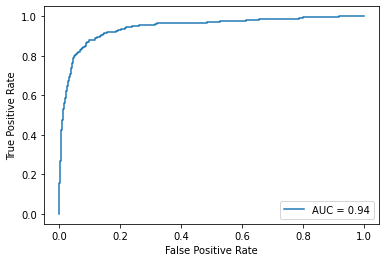

In [45]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

isoforest = IsolationForest(n_estimators=1000, contamination=percent_fraud)
isoforest.fit(Xtrain)
negative_depth = np.negative(isoforest.decision_function(Xtest))

fpr, tpr, thresholds = roc_curve(Ytest, negative_depth)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## Árbol de detección de fraude

Ahora vamos a comprobar si un método supervisado sencillo e interpretable, como es un árbol de decisión, puede ayudarnos a resolver este problema.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Entrena un árbol de decisión sobre los datos de train, haciendo uso tanto de las variables explicativas como de la variable objetivo. Trata de que el árbol sea sencillo, de forma que puedas generar una visualización interpretable del mismo. Mide también los resultados del árbol en AUC sobre el conjunto de test. ¿Obtienes mejoras sobre el modelo no supervisado?
</font>

***

Tree accuracy is 0.992185


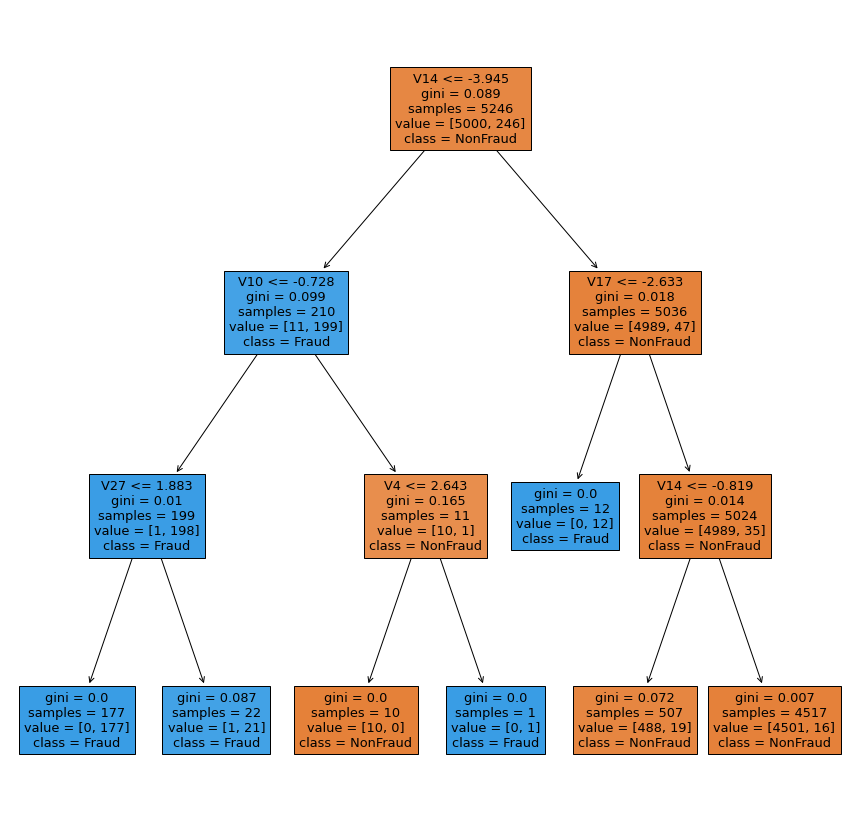

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


smalltree = DecisionTreeClassifier(max_depth=3)
smalltree.fit(Xtrain, Ytrain)

print("Tree accuracy is %f" % smalltree.score(Xtest, Ytest))

plt.figure(figsize=(15,15))
plot_tree(smalltree, feature_names=train[features].columns, class_names=["NonFraud", "Fraud"], filled=True)
plt.show()

In [47]:
roc_auc_score(Ytest, smalltree.predict_proba(Xtest)[:,1])

0.9474552845528456

Este árbol de decisión nos ofrece un **AUC** de 0.9474, pero no hemos optimizado ni limitado los parámetros. Hemos realizado esta visualización del árbol, porque el árbol completo era muy díficil de seguir y entender. Simplemente hemos representado el árbol con una porfundidad de 3.

A continuación vamos a caclular un nuevo Árbol de Decisión, optimizanddo y limitando los parámetros, utlizando el módulo **GridSearchCV**

Tree accuracy is 0.991041
DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=3,
                       min_impurity_decrease=0.001, min_samples_leaf=5)


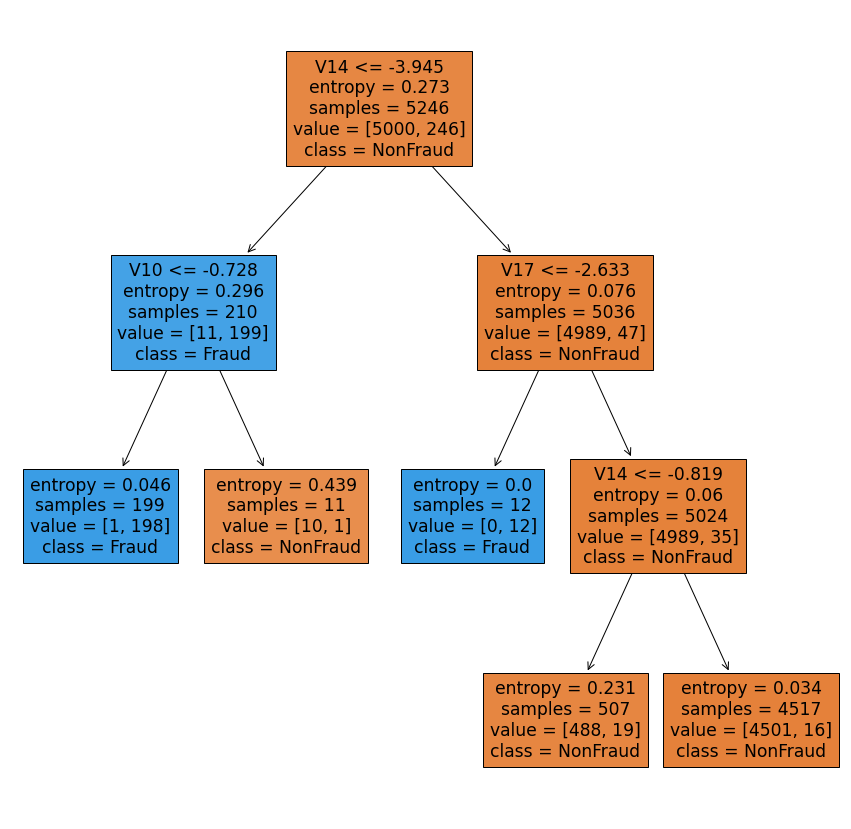

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid_crit = {
    "criterion" : ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4],
    "min_samples_split": [ 2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": [1e-3, 1e-2, 1e-1],
    "ccp_alpha": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
}

besttree = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = param_grid_crit,
    n_jobs=-1
)
besttree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % besttree.score(Xtest, Ytest))
print(besttree.best_estimator_)
plt.figure(figsize=(15,15))
plot_tree(besttree.best_estimator_, feature_names=train[features].columns, class_names=["NonFraud", "Fraud"], filled=True)
plt.show()

In [49]:
roc_auc_score(Ytest, besttree.best_estimator_.predict_proba(Xtest)[:,1])


0.9473479674796749

El nuevo Árbol modelizado tiene como parámetros, la entropia, como métrica de corte, una profunidad máxima de 3,  un mínimo de 5 hojas terminales, un descenso de la impureza de 0.001, y un mínimo de 5 observaciones para el corte. 

Este árbol obtiene un mejor **AUC** (0.9473) que el anterior.

In [50]:
auc_decision_tree = roc_auc_score(Ytest, besttree.best_estimator_.predict_proba(Xtest)[:,1])

## Modelos supervisados de ensemble

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Vamos a comprobar cómo es posible mejorar los resultados de detección usando métodos de ensemble. Entrena <b>al menos 5 de los métodos de ensemble vistos en clase</b>, y mide sus resultados de AUC en el test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Algunas sugerencias de modelos disponibles en scikit-learn que puedes utilizar:
    <ul>
        <li>Random Forest</li>
        <li>Extra Trees</li>
        <li>AdaBoost</li>
        <li>Gradient Boosting</li>
        <li>Bagging</li>
        <li>Voting</li>
        <li>Stacking</li>
    </ul>
No olvides que para medir correctamente el AUC, debes suministrar a esta métrica las <b>probabilidades de clase fraude</b> predichas por el modelo, las cuales puedes obtener mediante el método <i>predict_proba</i>.
    
Si has entrenado los modelos correctamente, tu mejor resultado debería ser de al menos un <b>97% de AUC</b> en test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Adicionalmente, se valorará:
    <ul>
        <li>Utilizar más técnicas de ensembles, además de las 5 mínimas requeridas</li>
        <li>Mejorar el AUC en test de tu modelo lo máximo posible</li>
        <li>Utilizar <a href=https://catboost.ai/>CatBoost</a> y/o <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, otras librerías de ensemble muy efectivas. Nótese que deberás instalar estas librerías en el entorno.</li>
    </ul>
</font>

***

In [51]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

def trainscore(X, y, Xte, yte, estimator):
    estimator.fit(X, y)
    score=estimator.predict_proba(Xte)[:,1]
    return roc_auc_score(yte, score)

trange = [1, 10, 20, 50, 100, 500, 1000]

aucs = {
        ntrees :
        trainscore(Xtrain,Ytrain,Xtest,Ytest , RandomForestClassifier(n_estimators = ntrees))
        for ntrees in trange
}

random_forest_df = pd.DataFrame({        
        "ntrees" : [ntrees for ntrees in aucs],
        "auc" : [aucs[ntrees]  for ntrees in aucs]
    })

random_forest_df

,ntrees,auc
0,1,0.878479
1,10,0.947753
2,20,0.966831
3,50,0.972485
4,100,0.980737
5,500,0.979025
6,1000,0.979989


El modelo con mayor **AUC** (0.980737), es el random forest con 100 árboles.

In [63]:
auc_random_forest = random_forest_df['auc'][4]

In [53]:
#Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

prof = [3,5,10,27,None]
trange = [1, 10, 100, 1000]

aucs = {
    profundidad: {
        ntrees :
        trainscore(Xtrain,Ytrain,Xtest,Ytest, ExtraTreesClassifier(n_estimators = ntrees, max_depth = profundidad))
        for ntrees in trange
    }
    for profundidad in prof
}

extra_trees_df = pd.DataFrame({
        "Profundidad" : [profundidad for profundidad in aucs for ntrees in aucs[profundidad]],
        "ntrees" : [ntrees for profundidad in aucs for ntrees in aucs[profundidad]],
        "auc" : [aucs[profundidad][ntrees] for profundidad in aucs for ntrees in aucs[profundidad]]
    })


extra_trees_df

,Profundidad,ntrees,auc
0,3.0,1,0.869008
1,3.0,10,0.970221
2,3.0,100,0.973010
3,3.0,1000,0.977935
4,5.0,1,0.811161
5,5.0,10,0.957431
6,5.0,100,0.974366
7,5.0,1000,0.978493
8,10.0,1,0.910303
9,10.0,10,0.971613


El modelo con mayor **AUC** (0.9838), es aquel que no tenía limitación de profundidad, y 1000 árboles.

In [67]:
auc_extra_trees = extra_trees_df['auc'][19]

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

base_learners = [
    ('lr', LogisticRegression()), 
    ('sgd', SGDClassifier()), 
    ('nb', GaussianNB()), 
    ('dt', DecisionTreeClassifier())
]

learning_rate = np.logspace(-5,0,6)

ada_boost_scores = pd.DataFrame.from_dict(
    data={
        mod_name: {
            'learning_rate: ' + str(learn): (
               roc_auc_score(Ytest, AdaBoostClassifier(
                    base_estimator=mod_obj, 
                    n_estimators=1000, 
                    algorithm='SAMME',  # SAMME.R requires predict_proba
                    learning_rate = learn
                ).fit(Xtrain,Ytrain).predict_proba(Xtest)[:,1])
            )
            for learn in learning_rate
        }
        for mod_name, mod_obj in base_learners
    },
    orient='index'
)
ada_boost_scores

,learning_rate: 1e-05,learning_rate: 0.0001,learning_rate: 0.001,learning_rate: 0.01,learning_rate: 0.1,learning_rate: 1.0
lr,0.678862,0.717480,0.894309,0.972946,0.974075,0.965156
sgd,0.892651,0.888236,0.903055,0.921793,0.945512,0.956820
nb,0.897949,0.899600,0.920488,0.960748,0.961071,0.938332
dt,0.923392,0.928092,0.917429,0.917894,0.923159,0.923057


El modelo de AdaBoost con mayor **AUC** (0.974075), es el que utiliza **Logistic Regression** y learning_rate = 0.1

In [56]:
auc_ada_boost = ada_boost_scores['learning_rate: 0.1']['lr']

In [57]:
from sklearn.ensemble import BaggingClassifier

base_learners = [
    ('lr', LogisticRegression()), 
    ('sgd', SGDClassifier()), 
    ('nb', GaussianNB()), 
    ('dt', DecisionTreeClassifier())
]

learning_rate = np.logspace(-5,0,6)

bagging = pd.DataFrame.from_dict(
    data={
        mod_name: {
            'learning_rate: ' + str(learn): (
               roc_auc_score(Ytest, BaggingClassifier(
                    base_estimator=mod_obj, 
                    n_estimators=1000, 
                    n_jobs=-1
                ).fit(Xtrain,Ytrain).predict_proba(Xtest)[:,1])
            )
            for learn in learning_rate
        }
        for mod_name, mod_obj in base_learners
    },
    orient='index'
)

bagging

,learning_rate: 1e-05,learning_rate: 0.0001,learning_rate: 0.001,learning_rate: 0.01,learning_rate: 0.1,learning_rate: 1.0
lr,0.974502,0.974349,0.974589,0.974297,0.974507,0.974750
sgd,0.959524,0.958700,0.956005,0.955733,0.957887,0.958226
nb,0.966952,0.967051,0.966935,0.967022,0.967003,0.966854
dt,0.975575,0.973863,0.975335,0.975067,0.974499,0.976379


El modelo de Bagging com mayor **AUC** (0.976464), es aquel que utiliza **DecisionTree** como modelo base y learning_rate: 1

In [68]:
auc_bagging = bagging['learning_rate: 1.0']['dt']

In [59]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

base_learners = [
    ('lr', LogisticRegression()),
    ('nb', GaussianNB()), 
    ('dt', DecisionTreeClassifier())
]

mixing_scores = pd.DataFrame.from_dict(
    data={'vote': (
                roc_auc_score(Ytest, VotingClassifier(
                    estimators=base_learners, 
                    n_jobs=-1,
                    voting='soft'
                ).fit(Xtrain,Ytrain).predict_proba(Xtest)[:,1])
            ),
            'stack': (
                roc_auc_score(Ytest, StackingClassifier(
                    estimators=base_learners, 
                    n_jobs=-1
                ).fit(Xtrain,Ytrain).predict_proba(Xtest)[:,1])
            )
        },
    orient='index'
)
mixing_scores

,0
vote,0.975296
stack,0.975416


Para los modelos de Voting y Stacking obtenemos unos **AUC** de 0.975296 y 0.975416, respectivamente.

In [60]:
auc_vote = mixing_scores[0]['vote']
auc_stack = mixing_scores[0]['stack']

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

n_jobs = 7
n_iter_search = 50

gradient_boosting =  {
        "param_dist" : {
            "n_estimators" : [50, 100, 1000],
            "loss": ["deviance", "exponential"],
            "learning_rate": np.logspace(-5,0,12),
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
            "subsample" : [0.1, 0.2, 0.5, 0.9, 1],
            "max_features": ["sqrt", "log2", None],
        }
    }

search = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=gradient_boosting['param_dist'], n_iter=n_iter_search, n_jobs=n_jobs)
auc_gradient_boosting = trainscore(Xtrain, Ytrain, Xtest, Ytest, search)
auc_gradient_boosting

0.972979674796748

In [65]:
search.best_params_

{'subsample': 0.9,
 'n_estimators': 1000,
 'min_samples_split': 64,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15,
 'loss': 'exponential',
 'learning_rate': 1.0}

Para Gradient Boosting probamos a utilizar la función RandomizedSearchCV para la optimización de hiperparametros con búsqueda aleatoria. Obtenemos un **AUC** de 0.97297 con los hiperparámetros mostrados.

## Visualización

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de todos tus modelos supervisados sobre el conjunto de test, junto con el modelo no supervisado. La visualización debe mostrar claramente cuál es el modelo con mayor AUC.
</font>

***

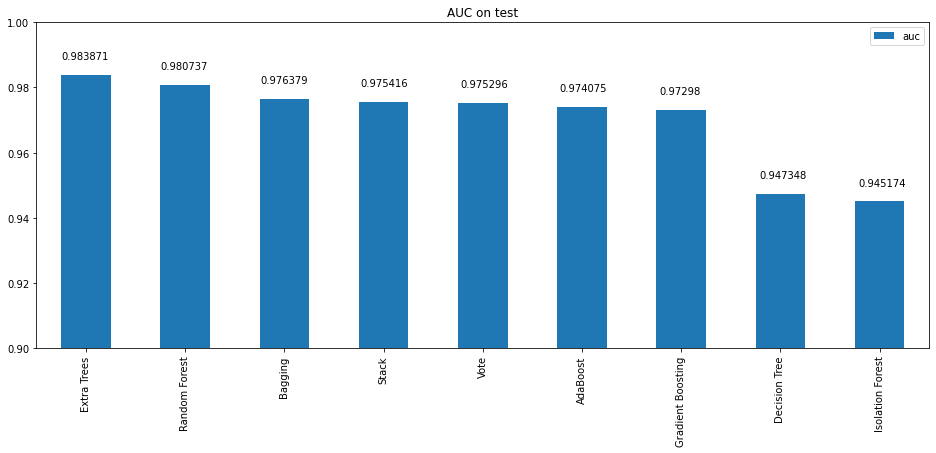

In [74]:
auc_scores = pd.DataFrame.from_dict(
    {
        "auc":
        {
        "Isolation Forest": round(auc_isolation_forest, 6),
        "Decision Tree": round(auc_decision_tree, 6),
        "Random Forest": round(auc_random_forest, 6),
        "Extra Trees": round(auc_extra_trees, 6),
        "AdaBoost": round(auc_ada_boost, 6),
        "Gradient Boosting": round(auc_gradient_boosting, 6),
        "Bagging": round(auc_bagging, 6),
        "Vote": round(auc_vote, 6),
        "Stack": round(auc_stack, 6)
    }
    }, orient = 'columns'
).sort_values(by=['auc'], ascending = False)
auc_scores

graph = auc_scores.plot(kind='bar', title='AUC on test', ylim=(0.9, 1.0), figsize=(16, 6))
for p in graph.patches:
    graph.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Vemos como el modelo que presenta el mayor AUC es el modelo **Extremely Randomized Trees (o extra-trees)**, el cual no tenía limitación de profundidad y utilizaba 1000 árboles.